In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import random
import shutil
import time

from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
import glob
import IPython.display as display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
normalpath_l2 = "/content/drive/MyDrive/TumorImage/normal/level2/*.png"
normalpath_l3 = "/content/drive/MyDrive/TumorImage/normal/level3/*.png"
normalpath_l4 = "/content/drive/MyDrive/TumorImage/normal/level4/*.png"

tumorpath_l2 = "/content/drive/MyDrive/TumorImage/tumor/level2/*.png"
tumorpath_l3 = "/content/drive/MyDrive/TumorImage/tumor/level3/*.png"
tumorpath_l4 = "/content/drive/MyDrive/TumorImage/tumor/level4/*.png"

normal_path_l2 = glob.glob(normalpath_l2)
normal_path_l3 = glob.glob(normalpath_l3)
normal_path_l4 = glob.glob(normalpath_l4)

tumor_path_l2 = glob.glob(tumorpath_l2)
tumor_path_l3 = glob.glob(tumorpath_l3)
tumor_path_l4 = glob.glob(tumorpath_l4)

print(f'length of image {len(normal_path_l2) + len(tumor_path_l2)}')

# sanity check
assert len(normal_path_l2) == len(normal_path_l3)
assert len(normal_path_l3) == len(normal_path_l4)

length of image 6768


level 2:


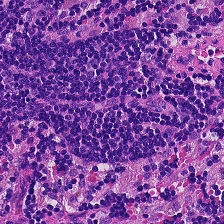

level 3:


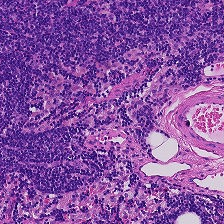

level 4:


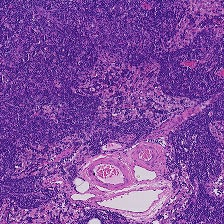

In [ ]:
print("level 2:")
display.display(display.Image(normal_path_l2[1000]))
print("level 3:")
display.display(display.Image(normal_path_l3[1000]))
print("level 4:")
display.display(display.Image(normal_path_l4[1000]))

In [ ]:
image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
def image_to_activations(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (224, 224))
  activations = tf.keras.applications.vgg16.preprocess_input(img)
  return activations, image_path

In [ ]:
all_img_path = normal_path_l2 + normal_path_l3 + normal_path_l4 + tumor_path_l2 + tumor_path_l3 + tumor_path_l4

activation_dataset = tf.data.Dataset.from_tensor_slices(all_img_path)
activation_dataset = activation_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Save all activations to disk in NumPy format
for img_batch, path_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())  

In [ ]:
raw_df = pd.DataFrame({'l2':normal_path_l2+tumor_path_l2, 'l3':normal_path_l3+tumor_path_l3, 'l4':normal_path_l4+tumor_path_l4})
zero_label = np.zeros(len(normal_path_l2)).tolist()
one_label = np.ones(len(tumor_path_l2)).tolist()
raw_df['label'] =  zero_label + one_label
raw_df.head()

,l2,l3,l4,label
0,/content/drive/MyDrive/TumorImage/normal/level...,/content/drive/MyDrive/TumorImage/normal/level...,/content/drive/MyDrive/TumorImage/normal/level...,0.0
1,/content/drive/MyDrive/TumorImage/normal/level...,/content/drive/MyDrive/TumorImage/normal/level...,/content/drive/MyDrive/TumorImage/normal/level...,0.0
2,/content/drive/MyDrive/TumorImage/normal/level...,/content/drive/MyDrive/TumorImage/normal/level...,/content/drive/MyDrive/TumorImage/normal/level...,0.0
3,/content/drive/MyDrive/TumorImage/normal/level...,/content/drive/MyDrive/TumorImage/normal/level...,/content/drive/MyDrive/TumorImage/normal/level...,0.0
4,/content/drive/MyDrive/TumorImage/normal/level...,/content/drive/MyDrive/TumorImage/normal/level...,/content/drive/MyDrive/TumorImage/normal/level...,0.0


In [ ]:
train_df, test_df = train_test_split(raw_df, test_size = 0.2)

In [ ]:
train_df, val_df = train_test_split(train_df, test_size = 0.2)

In [ ]:
print(train_df.shape,val_df.shape,test_df.shape)

(4331, 4) (1083, 4) (1354, 4)


In [ ]:
l2_train = train_df['l2'].tolist()
l3_train = train_df['l3'].tolist()
l4_train = train_df['l4'].tolist()
label_train = train_df['label'].tolist()

In [ ]:
l2_val = val_df['l2'].tolist()
l3_val= val_df['l3'].tolist()
l4_val = val_df['l4'].tolist()
label_val = val_df['label'].tolist()

In [ ]:
l2_test = test_df['l2'].tolist()
l3_test = test_df['l3'].tolist()
l4_test = test_df['l4'].tolist()
label_test = test_df['label'].tolist()

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [ ]:
def load_np(l2_path, l3_path, answer):
  l2_activations = np.load(l2_path.decode('utf-8')+'.npy')
  l3_activations = np.load(l3_path.decode('utf-8')+'.npy')
  return l2_activations, l3_activations, answer, l2_path, l3_path

In [ ]:
def create_dataset(l2_path, l3_path, answers):
  dataset = tf.data.Dataset.from_tensor_slices((l2_path, 
                                                l3_path, 
                                                answers))
  # Load the cached activations off disk
  # Note: This is not the clearest code in the world (it's on our list to 
  # update on the website, so it's implemented for you in this assignment)
  dataset = dataset.map(lambda x, y, z: tf.numpy_function(
      load_np, [x, y, z], [tf.float32, tf.float32, tf.float32, tf.string, tf.string]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
train_ds = create_dataset(l2_train, l3_train, label_train)
val_ds = create_dataset(l2_val, l3_val, label_val)
test_ds = create_dataset(l2_test, l3_test, label_test)

### Sanity Check
check the size of train_ds

In [ ]:
my_iterator = iter(train_ds)
activations_l2, activation_l3, answers_batch, l2_paths_batch, l3_path_batch = next(my_iterator)

print(activations_l2.shape,
      activation_l3.shape, 
      answers_batch.shape, 
      l2_paths_batch.shape, 
      l3_path_batch.shape)

(32, 7, 7, 512) (32, 7, 7, 512) (32,) (32,) (32,)


### Model 1: Combine l2 and l3

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Dropout
from tensorflow.keras.models import Model, Sequential

In [ ]:
l2_input = Input(shape=(7,7,512))
l3_input = Input(shape=(7,7,512))
vision_model = Sequential()

gap_l2 = tf.keras.layers.GlobalAveragePooling2D()(l2_input)
gap_l3 = tf.keras.layers.GlobalAveragePooling2D()(l3_input)
#vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
#l2_encoded_image = vision_model(l2_input)
#l3_encoded_image = vision_model(l3_input)
#merged = tf.keras.layers.concatenate([l2_encoded_image, l3_encoded_image])
l2_vec = Flatten(name = 'flatten_l2')(gap_l2)
l3_vec = Flatten(name = 'flatten_l3')(gap_l3)

concat_layer = tf.keras.layers.concatenate([l2_vec, l3_vec], axis = -1, name = 'concat')
concat_dropout = Dropout(0.2)(concat_layer)

dense1_layer = Dense(1024, activation='relu')(concat_dropout)
dense1_dropout = Dropout(0.2)(dense1_layer)
dense2_layer = Dense(1, activation='sigmoid')(dense1_dropout)

# vision_model.add(tf.keras.layers.concatenate([l2_encoded_image, l3_encoded_image]))
# vision_model.add(Dense(1024, activation='relu'))
# vision_model.add(Dropout(rate=0.2))
# vision_model.add(Dense(1, activation='sigmoid'))
model1 = Model([l2_input, l3_input], dense2_layer)

In [ ]:
model1.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 7, 7, 512)]  0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 7, 7, 512)]  0                                            
__________________________________________________________________________________________________
global_average_pooling2d_14 (Gl (None, 512)          0           input_16[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_15 (Gl (None, 512)          0           input_17[0][0]                   
____________________________________________________________________________________________

In [ ]:
model1.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

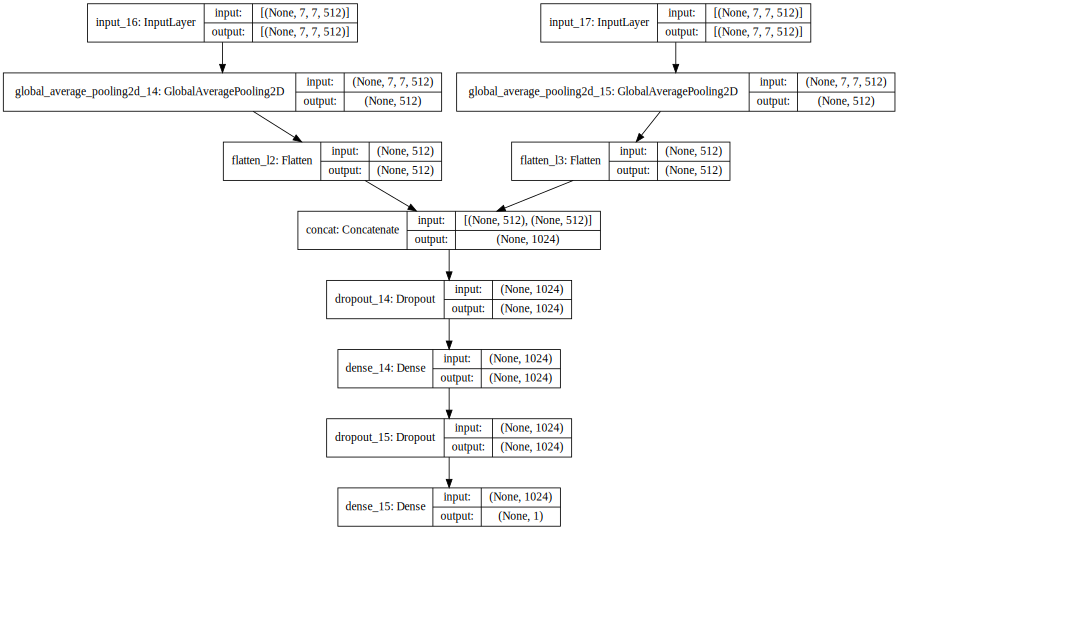

In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot

os.environ["PATH"] += os.pathsep + "/usr/bin/dot"

# plot NCF model architecture
SVG(model_to_dot(model1, dpi=60, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
activations_l2, activations_l3, answers_batch, path_batch_l2, path_batch_l3 = next(iter(train_ds))

In [ ]:
loss_list = []
acc_list = []
for _ in range(100):
  metrics2 = model1.train_on_batch([activations_l2, activations_l3], answers_batch)
  loss_list.append(metrics2[0])
  acc_list.append(metrics2[1])

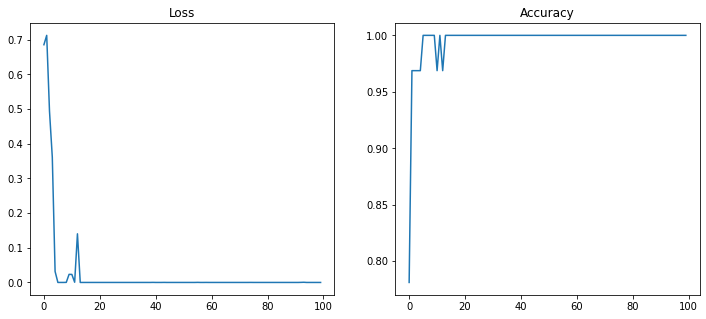

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.title.set_text('Loss')
ax2.title.set_text('Accuracy')
ax1.plot(loss_list)
ax2.plot(acc_list)

### Checkpoint

In [ ]:
drive_root = '/drive/My Drive/'
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "final_model1")

# Used for formatting
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

In [ ]:
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /drive/My Drive/checkpoints/final_model1
Checkpoints folder already exists


### Restore the latest checkpoint (if it exists).

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model1.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from /drive/My Drive/checkpoints/final_model1/cp-00000000.ckpt


In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

### Code to evaluate on the validation dataset
The validation dataset may be large. It would be wasteful to evaluate on the entire validation dataset each training epoch. Instead, you could evaluate every N epochs, or, you can use the below methoid to evaluate for a fixed number of steps (batches). This will give you a noisier evaluation, but a useful indicator of how your model is doing over time.

In [ ]:
def evaluate(given_model, valid_ds, max_steps=None):
  steps = 0
  for activations_l2, activations_l3, answers_batch, path_batch_l2, path_batch_l3 in valid_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = given_model.predict(x=[activations_l2, activations_l3])
    steps += 1 
    # Record metrics after each batch
    val_loss(answers_batch, predictions)
    val_accuracy(answers_batch, predictions)

### Train the model

In [ ]:
# Your code here
# Complete this cell (there are only a few parts to write)

# Used to track loss and accuracy as we go
# You should not need to modify these
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10 # Your code here

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for activations_l2, activations_l3, answers_batch, path_batch_l2, path_batch_l3 in train_ds:
    result = model1.train_on_batch(x=[activations_l2, activations_l3], y=answers_batch)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate(model1, val_ds, max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Your code here
  # Save a checkpoint after each epoch
  print("Saving weights")
  model1.save_weights(checkpoint_path.format(epoch=0))

Epoch 0, Loss: 0.04, Accuracy: 98.53, Val Loss 0.06, Val Accuracy 98.25, Time: 15.9 secs
Saving weights
Epoch 1, Loss: 0.04, Accuracy: 98.44, Val Loss 0.06, Val Accuracy 98.33, Time: 15.3 secs
Saving weights
Epoch 2, Loss: 0.04, Accuracy: 98.60, Val Loss 0.07, Val Accuracy 98.07, Time: 15.5 secs
Saving weights
Epoch 3, Loss: 0.04, Accuracy: 98.69, Val Loss 0.10, Val Accuracy 98.02, Time: 16.0 secs
Saving weights
Epoch 4, Loss: 0.03, Accuracy: 98.81, Val Loss 0.08, Val Accuracy 97.23, Time: 15.7 secs
Saving weights
Epoch 5, Loss: 0.03, Accuracy: 98.94, Val Loss 0.07, Val Accuracy 98.16, Time: 15.6 secs
Saving weights
Epoch 6, Loss: 0.04, Accuracy: 98.74, Val Loss 0.08, Val Accuracy 98.16, Time: 15.5 secs
Saving weights
Epoch 7, Loss: 0.03, Accuracy: 99.06, Val Loss 0.06, Val Accuracy 98.24, Time: 15.7 secs
Saving weights
Epoch 8, Loss: 0.03, Accuracy: 98.87, Val Loss 0.10, Val Accuracy 98.16, Time: 15.7 secs
Saving weights
Epoch 9, Loss: 0.04, Accuracy: 98.60, Val Loss 0.07, Val Accurac

In [ ]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model1.load_weights(latest)
print("loaded weights from", latest)

Text(0.5, 1.0, 'val accuracy')

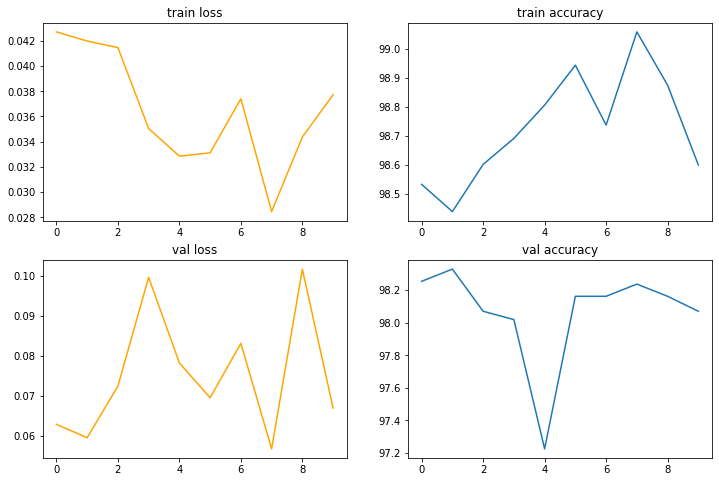

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(train_loss_history, color='orange')
axs[0, 1].plot(train_acc_history)
axs[1, 0].plot(val_loss_history, color='orange')
axs[1, 1].plot(val_acc_history)
axs[0, 0].set_title('train loss')
axs[0, 1].set_title('train accuracy')
axs[1, 0].set_title('val loss')
axs[1, 1].set_title('val accuracy')

### Test

In [ ]:
test_loss_history, test_acc_history = [], []
test_loss = tf.keras.metrics.BinaryCrossentropy(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

for activations_l2, activations_l3, answers_batch, path_batch_l2, path_batch_l3 in test_ds:
  predictions = model1.predict(x=[activations_l2, activations_l3])
  # Record metrics after each batch
  test_loss(answers_batch, predictions)
  test_accuracy(answers_batch, predictions)

In [ ]:
print('Test accuracy: ' + str(test_accuracy.result().numpy()))
print('Test loss: ' + str(test_loss.result().numpy()))

Test accuracy: 0.9854651
Test loss: 0.045879003


### Model 2: Combine L2 and L4

In [ ]:
train_ds = create_dataset(l2_train, l4_train, label_train)
val_ds = create_dataset(l2_val, l4_val, label_val)
test_ds = create_dataset(l2_test, l4_test, label_test)

In [ ]:
l2_input = Input(shape=(7,7,512))
l4_input = Input(shape=(7,7,512))
vision_model = Sequential()

gap_l2 = tf.keras.layers.GlobalAveragePooling2D()(l2_input)
gap_l4 = tf.keras.layers.GlobalAveragePooling2D()(l4_input)
#vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
#l2_encoded_image = vision_model(l2_input)
#l3_encoded_image = vision_model(l3_input)
#merged = tf.keras.layers.concatenate([l2_encoded_image, l3_encoded_image])
l2_vec = Flatten(name = 'flatten_l2')(gap_l2)
l4_vec = Flatten(name = 'flatten_l4')(gap_l4)

concat_layer = tf.keras.layers.concatenate([l2_vec, l4_vec], axis = -1, name = 'concat')
concat_dropout = Dropout(0.2)(concat_layer)

dense1_layer = Dense(1024, activation='relu')(concat_dropout)
dense1_dropout = Dropout(0.2)(dense1_layer)
dense2_layer = Dense(1, activation='sigmoid')(dense1_dropout)

# vision_model.add(tf.keras.layers.concatenate([l2_encoded_image, l3_encoded_image]))
# vision_model.add(Dense(1024, activation='relu'))
# vision_model.add(Dropout(rate=0.2))
# vision_model.add(Dense(1, activation='sigmoid'))
model2 = Model([l2_input, l4_input], dense2_layer)

In [ ]:
model2.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

In [ ]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10 # Your code here

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for activations_l2, activations_l4, answers_batch, path_batch_l2, path_batch_l3 in train_ds:
    result = model2.train_on_batch(x=[activations_l2, activations_l4], y=answers_batch)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate(model2, val_ds, max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Your code here
  # Save a checkpoint after each epoch
  # print("Saving weights")
  # model1.save_weights(checkpoint_path.format(epoch=0))

Epoch 0, Loss: 0.29, Accuracy: 95.47, Val Loss 0.09, Val Accuracy 97.87, Time: 18.9 secs
Epoch 1, Loss: 0.16, Accuracy: 96.62, Val Loss 0.15, Val Accuracy 97.98, Time: 15.5 secs
Epoch 2, Loss: 0.13, Accuracy: 97.17, Val Loss 0.12, Val Accuracy 97.96, Time: 15.6 secs
Epoch 3, Loss: 0.09, Accuracy: 97.36, Val Loss 0.05, Val Accuracy 98.13, Time: 15.5 secs
Epoch 4, Loss: 0.06, Accuracy: 98.02, Val Loss 0.07, Val Accuracy 98.40, Time: 15.5 secs
Epoch 5, Loss: 0.06, Accuracy: 97.82, Val Loss 0.06, Val Accuracy 98.07, Time: 15.5 secs
Epoch 6, Loss: 0.06, Accuracy: 97.95, Val Loss 0.04, Val Accuracy 98.53, Time: 15.3 secs
Epoch 7, Loss: 0.06, Accuracy: 98.12, Val Loss 0.04, Val Accuracy 98.25, Time: 15.4 secs
Epoch 8, Loss: 0.04, Accuracy: 98.41, Val Loss 0.04, Val Accuracy 98.44, Time: 15.4 secs
Epoch 9, Loss: 0.04, Accuracy: 98.71, Val Loss 0.06, Val Accuracy 97.58, Time: 15.3 secs


Text(0.5, 1.0, 'val accuracy')

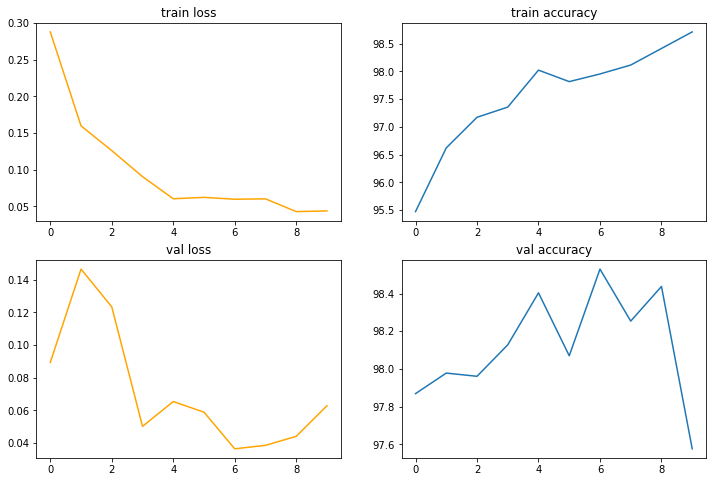

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(train_loss_history, color='orange')
axs[0, 1].plot(train_acc_history)
axs[1, 0].plot(val_loss_history, color='orange')
axs[1, 1].plot(val_acc_history)
axs[0, 0].set_title('train loss')
axs[0, 1].set_title('train accuracy')
axs[1, 0].set_title('val loss')
axs[1, 1].set_title('val accuracy')

In [ ]:
test_loss_history, test_acc_history = [], []
test_loss = tf.keras.metrics.BinaryCrossentropy(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

for activations_l2, activations_l4, answers_batch, path_batch_l2, path_batch_l4 in test_ds:
  predictions = model2.predict(x=[activations_l2, activations_l4])
  # Record metrics after each batch
  test_loss(answers_batch, predictions)
  test_accuracy(answers_batch, predictions)

In [ ]:
print('Test accuracy: ' + str(test_accuracy.result().numpy()))
print('Test loss: ' + str(test_loss.result().numpy()))

Test accuracy: 0.9722384
Test loss: 0.07226971


### Model 3: L2, L3, L4

In [ ]:
def load_np_for_three(l2_path, l3_path, l4_path, answer):
  l2_activations = np.load(l2_path.decode('utf-8')+'.npy')
  l3_activations = np.load(l3_path.decode('utf-8')+'.npy')
  l4_activations = np.load(l4_path.decode('utf-8')+'.npy')
  return l2_activations, l3_activations, l4_activations, answer, l2_path, l3_path, l4_path

In [ ]:
def create_dataset_for_three(l2_path, l3_path, l4_path, answers):
  dataset = tf.data.Dataset.from_tensor_slices((l2_path, l3_path, l4_path, answers))
  # Load the cached activations off disk
  # Note: This is not the clearest code in the world (it's on our list to 
  # update on the website, so it's implemented for you in this assignment)
  dataset = dataset.map(lambda x, y, y2, z: tf.numpy_function(
      load_np_for_three, [x, y, y2, z], [tf.float32, tf.float32, tf.float32, tf.float32, tf.string, tf.string, tf.string]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
train_ds = create_dataset_for_three(l2_train, l3_train, l4_train, label_train)
val_ds = create_dataset_for_three(l2_val, l3_val, l4_val, label_val)
test_ds = create_dataset_for_three(l2_test, l3_test, l4_test, label_test)

In [ ]:
l2_input = Input(shape=(7,7,512))
l3_input = Input(shape=(7,7,512))
l4_input = Input(shape=(7,7,512))
vision_model = Sequential()

gap_l2 = tf.keras.layers.GlobalAveragePooling2D()(l2_input)
gap_l3 = tf.keras.layers.GlobalAveragePooling2D()(l3_input)
gap_l4 = tf.keras.layers.GlobalAveragePooling2D()(l4_input)
#vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
#l2_encoded_image = vision_model(l2_input)
#l3_encoded_image = vision_model(l3_input)
#merged = tf.keras.layers.concatenate([l2_encoded_image, l3_encoded_image])
l2_vec = Flatten(name = 'flatten_l2')(gap_l2)
l3_vec = Flatten(name = 'flatten_l3')(gap_l3)
l4_vec = Flatten(name = 'flatten_l4')(gap_l4)

concat_layer = tf.keras.layers.concatenate([l2_vec, l3_vec, l4_vec], axis = -1, name = 'concat')
concat_dropout = Dropout(0.2)(concat_layer)

dense1_layer = Dense(1024, activation='relu')(concat_dropout)
dense1_dropout = Dropout(0.2)(dense1_layer)
dense2_layer = Dense(1, activation='sigmoid')(dense1_dropout)

# vision_model.add(tf.keras.layers.concatenate([l2_encoded_image, l3_encoded_image]))
# vision_model.add(Dense(1024, activation='relu'))
# vision_model.add(Dropout(rate=0.2))
# vision_model.add(Dense(1, activation='sigmoid'))
model3 = Model([l2_input, l3_input, l4_input], dense2_layer)

In [ ]:
model3.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 7, 7, 512)]  0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 7, 7, 512)]  0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 7, 7, 512)]  0                                            
__________________________________________________________________________________________________
global_average_pooling2d_10 (Gl (None, 512)          0           input_12[0][0]                   
____________________________________________________________________________________________

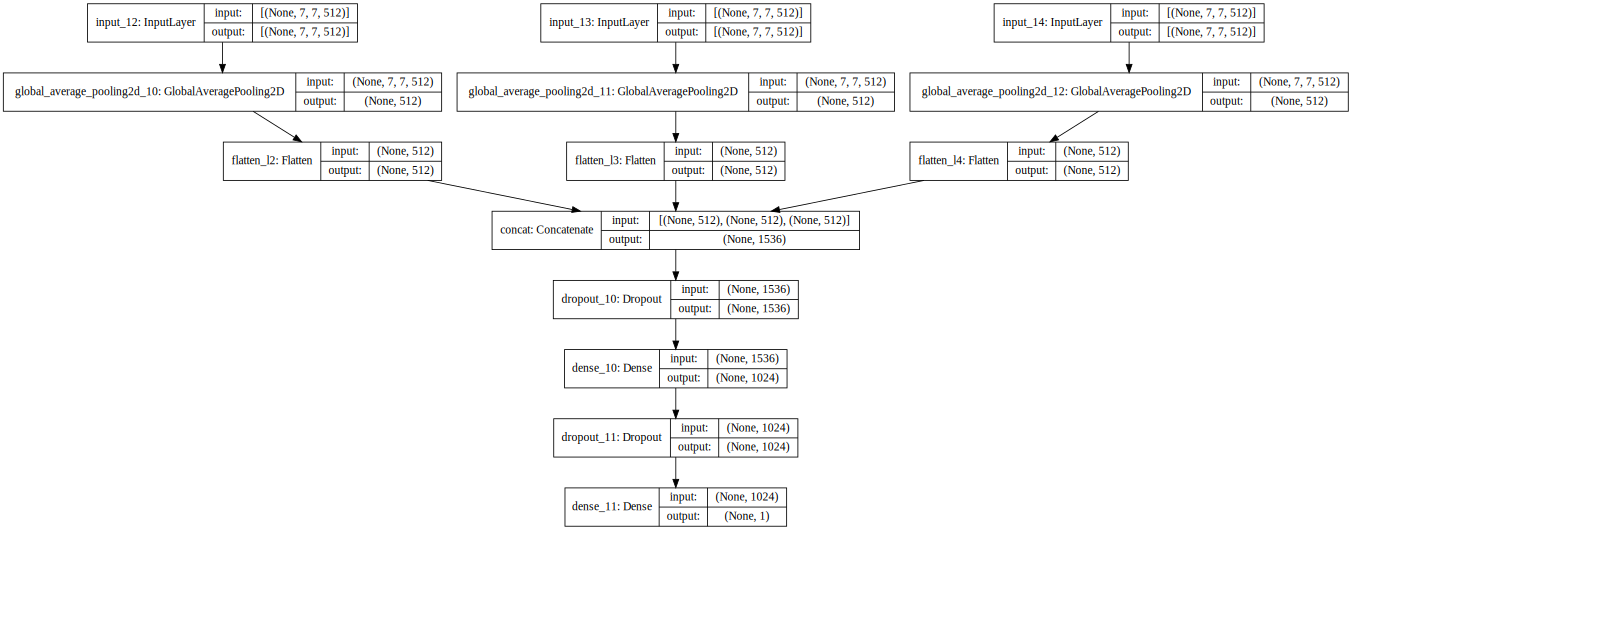

In [ ]:
os.environ["PATH"] += os.pathsep + "/usr/bin/dot"

# plot NCF model architecture
SVG(model_to_dot(model3, dpi=60, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model3.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

In [ ]:
def evaluate_for_three(given_model, valid_ds, max_steps=None):
  steps = 0
  for activations_l2, activations_l3, activations_l4, answers_batch, path_batch_l2, path_batch_l3, path_batch_l4 in valid_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = given_model.predict(x=[activations_l2, activations_l3, activations_l4])
    steps += 1 
    # Record metrics after each batch
    val_loss(answers_batch, predictions)
    val_accuracy(answers_batch, predictions)

In [ ]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10 # Your code here

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for activations_l2, activations_l3, activations_l4, answers_batch, path_batch_l2, path_batch_l3, path_batch_l4 in train_ds:
    result = model3.train_on_batch(x=[activations_l2, activations_l3, activations_l4], y=answers_batch)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate_for_three(model3, val_ds, max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Your code here
  # Save a checkpoint after each epoch
  # print("Saving weights")
  # model1.save_weights(checkpoint_path.format(epoch=0))

Epoch 0, Loss: 0.55, Accuracy: 95.24, Val Loss 0.08, Val Accuracy 97.85, Time: 22.6 secs
Epoch 1, Loss: 0.10, Accuracy: 97.22, Val Loss 0.06, Val Accuracy 98.07, Time: 21.7 secs
Epoch 2, Loss: 0.07, Accuracy: 98.02, Val Loss 0.08, Val Accuracy 97.78, Time: 21.6 secs
Epoch 3, Loss: 0.06, Accuracy: 98.30, Val Loss 0.06, Val Accuracy 98.25, Time: 21.5 secs
Epoch 4, Loss: 0.05, Accuracy: 98.32, Val Loss 0.09, Val Accuracy 97.87, Time: 21.5 secs
Epoch 5, Loss: 0.05, Accuracy: 98.25, Val Loss 0.06, Val Accuracy 98.40, Time: 21.5 secs
Epoch 6, Loss: 0.05, Accuracy: 98.41, Val Loss 0.05, Val Accuracy 98.40, Time: 21.5 secs
Epoch 7, Loss: 0.04, Accuracy: 98.85, Val Loss 0.05, Val Accuracy 98.07, Time: 21.6 secs
Epoch 8, Loss: 0.05, Accuracy: 98.23, Val Loss 0.10, Val Accuracy 97.96, Time: 21.8 secs
Epoch 9, Loss: 0.07, Accuracy: 97.93, Val Loss 0.05, Val Accuracy 98.16, Time: 21.4 secs


Text(0.5, 1.0, 'val accuracy')

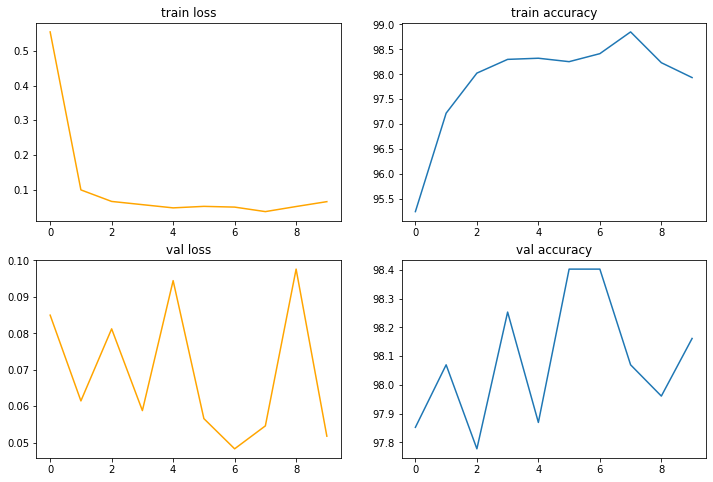

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(train_loss_history, color='orange')
axs[0, 1].plot(train_acc_history)
axs[1, 0].plot(val_loss_history, color='orange')
axs[1, 1].plot(val_acc_history)
axs[0, 0].set_title('train loss')
axs[0, 1].set_title('train accuracy')
axs[1, 0].set_title('val loss')
axs[1, 1].set_title('val accuracy')

In [ ]:
test_loss_history, test_acc_history = [], []
test_loss = tf.keras.metrics.BinaryCrossentropy(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

for activations_l2, activations_l3, activations_l4, answers_batch, path_batch_l2, path_batch_l3, path_batch_l4 in test_ds:
  predictions = model3.predict(x=[activations_l2, activations_l3, activations_l4])
  # Record metrics after each batch
  test_loss(answers_batch, predictions)
  test_accuracy(answers_batch, predictions)

In [ ]:
print('Test accuracy: ' + str(test_accuracy.result().numpy()))
print('Test loss: ' + str(test_loss.result().numpy()))

Test accuracy: 0.98619187
Test loss: 0.039271913


### Model4: Single Level Model

In [ ]:
def load_np_for_one(l2_path, answer):
  l2_activations = np.load(l2_path.decode('utf-8')+'.npy')
  return l2_activations, answer, l2_path

In [ ]:
def create_dataset_for_one(l2_path, answers):
  dataset = tf.data.Dataset.from_tensor_slices((l2_path, answers))
  # Load the cached activations off disk
  # Note: This is not the clearest code in the world (it's on our list to 
  # update on the website, so it's implemented for you in this assignment)
  dataset = dataset.map(lambda x, z: tf.numpy_function(
      load_np_for_one, [x, z], [tf.float32, tf.float32, tf.string]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
train_ds = create_dataset_for_one(l2_train, label_train)
val_ds = create_dataset_for_one(l2_val, label_val)
test_ds = create_dataset_for_one(l2_test, label_test)

In [ ]:
l2_input = Input(shape=(7,7,512))

vision_model = Sequential()

gap_l2 = tf.keras.layers.GlobalAveragePooling2D()(l2_input)

#vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
#l2_encoded_image = vision_model(l2_input)
#l3_encoded_image = vision_model(l3_input)
#merged = tf.keras.layers.concatenate([l2_encoded_image, l3_encoded_image])
l2_vec = Flatten(name = 'flatten_l2')(gap_l2)
flatten_dropout = Dropout(0.2)(l2_vec)

dense1_layer = Dense(1024, activation='relu')(flatten_dropout)
dense1_dropout = Dropout(0.2)(dense1_layer)
dense2_layer = Dense(1, activation='sigmoid')(dense1_dropout)

# vision_model.add(tf.keras.layers.concatenate([l2_encoded_image, l3_encoded_image]))
# vision_model.add(Dense(1024, activation='relu'))
# vision_model.add(Dropout(rate=0.2))
# vision_model.add(Dense(1, activation='sigmoid'))
model4 = Model(l2_input, dense2_layer)

In [ ]:
model4.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 7, 7, 512)]       0         
_________________________________________________________________
global_average_pooling2d_13  (None, 512)               0         
_________________________________________________________________
flatten_l2 (Flatten)         (None, 512)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 1025

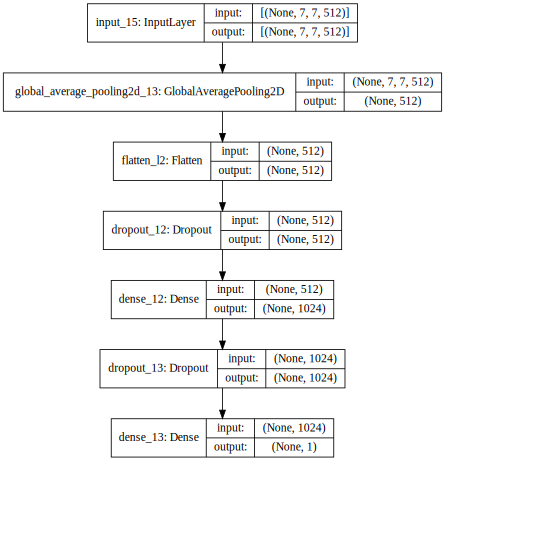

In [ ]:
os.environ["PATH"] += os.pathsep + "/usr/bin/dot"

# plot NCF model architecture
SVG(model_to_dot(model4, dpi=60, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model4.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

In [ ]:
def evaluate_for_one(given_model, valid_ds, max_steps=None):
  steps = 0
  for activations_l2, answers_batch, path_batch_l2 in valid_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = given_model.predict(x=activations_l2)
    steps += 1 
    # Record metrics after each batch
    val_loss(answers_batch, predictions)
    val_accuracy(answers_batch, predictions)

In [ ]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10 # Your code here

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for activations_l2, answers_batch, path_batch_l2 in train_ds:
    result = model4.train_on_batch(x=activations_l2, y=answers_batch)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate_for_one(model4, val_ds, max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Your code here
  # Save a checkpoint after each epoch
  # print("Saving weights")
  # model1.save_weights(checkpoint_path.format(epoch=0))

Epoch 0, Loss: 0.32, Accuracy: 95.24, Val Loss 0.19, Val Accuracy 97.43, Time: 9.8 secs
Epoch 1, Loss: 0.15, Accuracy: 96.62, Val Loss 0.16, Val Accuracy 96.95, Time: 9.2 secs
Epoch 2, Loss: 0.14, Accuracy: 96.51, Val Loss 0.09, Val Accuracy 97.89, Time: 9.3 secs
Epoch 3, Loss: 0.10, Accuracy: 97.01, Val Loss 0.13, Val Accuracy 97.19, Time: 9.0 secs
Epoch 4, Loss: 0.09, Accuracy: 97.45, Val Loss 0.06, Val Accuracy 97.98, Time: 9.1 secs
Epoch 5, Loss: 0.08, Accuracy: 97.56, Val Loss 0.06, Val Accuracy 98.07, Time: 9.0 secs
Epoch 6, Loss: 0.07, Accuracy: 97.54, Val Loss 0.07, Val Accuracy 97.61, Time: 9.0 secs
Epoch 7, Loss: 0.08, Accuracy: 97.86, Val Loss 0.07, Val Accuracy 98.07, Time: 9.0 secs
Epoch 8, Loss: 0.07, Accuracy: 97.73, Val Loss 0.06, Val Accuracy 97.96, Time: 9.1 secs
Epoch 9, Loss: 0.07, Accuracy: 97.86, Val Loss 0.07, Val Accuracy 97.85, Time: 9.2 secs


Text(0.5, 1.0, 'val accuracy')

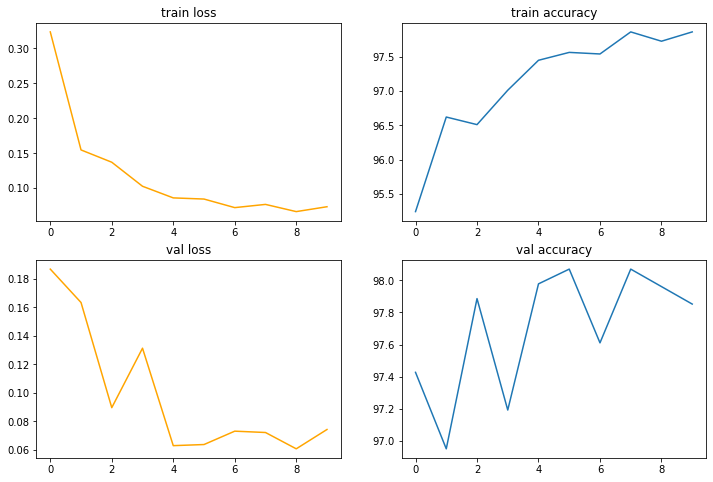

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(train_loss_history, color='orange')
axs[0, 1].plot(train_acc_history)
axs[1, 0].plot(val_loss_history, color='orange')
axs[1, 1].plot(val_acc_history)
axs[0, 0].set_title('train loss')
axs[0, 1].set_title('train accuracy')
axs[1, 0].set_title('val loss')
axs[1, 1].set_title('val accuracy')

In [ ]:
test_loss_history, test_acc_history = [], []
test_loss = tf.keras.metrics.BinaryCrossentropy(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

for activations_l2, answers_batch, path_batch_l2 in test_ds:
  predictions = model4.predict(x=activations_l2)
  # Record metrics after each batch
  test_loss(answers_batch, predictions)
  test_accuracy(answers_batch, predictions)

In [ ]:
print('Test accuracy: ' + str(test_accuracy.result().numpy()))
print('Test loss: ' + str(test_loss.result().numpy()))

Test accuracy: 0.97965115
Test loss: 0.07177011


### Best Model ROC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
predictions_m4, labels_m4 = [], []

for activations_l2, answers_batch, path_batch_l2 in test_ds:
  pred = model4.predict(x=activations_l2).ravel()
  # Record metrics after each batch
  labels_m4 += answers_batch.numpy().tolist()
  predictions_m4 += pred.tolist()

In [ ]:
test_ds1 = create_dataset(l2_test, l3_test, label_test)

predictions_m1, labels_m1 = [], []

for activations_l2, activations_l3, answers_batch, path_batch_l2, path_batch_l3 in test_ds:
  pred = model1.predict(x=[activations_l2, activations_l3]).ravel()
  # Record metrics after each batch
  labels_m1 += answers_batch.numpy().tolist()
  predictions_m1 += pred.tolist()

In [ ]:
test_ds2 = create_dataset(l2_test, l4_test, label_test)

predictions_m2, labels_m2 = [], []

for activations_l2, activations_l4, answers_batch, path_batch_l2, path_batch_l4 in test_ds2:
  pred = model2.predict(x=[activations_l2, activations_l4]).ravel()
  # Record metrics after each batch
  labels_m2 += answers_batch.numpy().tolist()
  predictions_m2 += pred.tolist()

In [ ]:
test_ds3 = create_dataset_for_three(l2_test, l3_test, l4_test, label_test)

predictions_m3, labels_m3 = [], []

for activations_l2, activations_l3, activations_l4, answers_batch, path_batch_l2, path_batch_l3, path_batch_l4 in test_ds3:
  pred = model3.predict(x=[activations_l2, activations_l3, activations_l4]).ravel()
  # Record metrics after each batch
  labels_m3 += answers_batch.numpy().tolist()
  predictions_m3 += pred.tolist()

In [ ]:
fpr_m4, tpr_m4, thresholds_m4 = roc_curve(labels_m4, predictions_m4)
auc_m4 = auc(fpr_m4, tpr_m4)

fpr_m1, tpr_m1, thresholds_m1 = roc_curve(labels_m1, predictions_m1)
auc_m1 = auc(fpr_m1, tpr_m1)

fpr_m2, tpr_m2, thresholds_m2 = roc_curve(labels_m2, predictions_m2)
auc_m2 = auc(fpr_m2, tpr_m2)

fpr_m3, tpr_m3, thresholds_m3 = roc_curve(labels_m3, predictions_m3)
auc_m3 = auc(fpr_m3, tpr_m3)

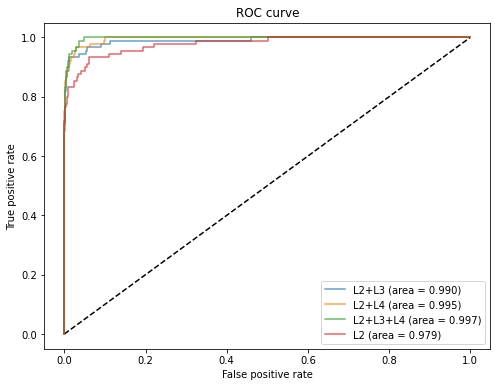

In [ ]:
plt.figure(1, figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_m1, tpr_m1, label='L2+L3 (area = {:.3f})'.format(auc_m1), alpha=0.7)
plt.plot(fpr_m2, tpr_m2, label='L2+L4 (area = {:.3f})'.format(auc_m2), alpha=0.7)
plt.plot(fpr_m3, tpr_m3, label='L2+L3+L4 (area = {:.3f})'.format(auc_m3), alpha=0.7)
plt.plot(fpr_m4, tpr_m4, label='L2 (area = {:.3f})'.format(auc_m4), alpha=0.7)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Heatmap (multi-layer patch overlay)

In [ ]:
# test_ds3 = create_dataset_for_three(l2_test, l3_test, l4_test, label_test)

# predictions_m3, labels_m3 = [], []

# for activations_l2, activations_l3, activations_l4, answers_batch, path_batch_l2, path_batch_l3, path_batch_l4 in test_ds3:
#   pred = model3.predict(x=[activations_l2, activations_l3, activations_l4]).ravel()
#   # Record metrics after each batch
#   labels_m3 += answers_batch.numpy().tolist()
#   predictions_m3 += pred.tolist()

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (214 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [ ]:
from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray

In [ ]:
slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  97.9M      0  0:00:05  0:00:05 --:--:-- 97.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  19.7M      0 --:--:-- --:--:-- --:--:-- 19.6M


In [ ]:
os.chdir('/content')

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, slide.level_dimensions[0][0], slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif


In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where((im_gray <= intensity) & (im_gray > 0))
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [ ]:
slide_image = read_slide(slide, x=0, y=0, level=6, width=slide.level_dimensions[6][0], height=slide.level_dimensions[6][1])
print(slide_image.shape)

mask_image = read_slide(tumor_mask, x=0, y=0, level=6, width=slide.level_dimensions[6][0], height=slide.level_dimensions[6][1])

(840, 960, 3)


In [ ]:
def create_patch(slice, level, p_size, is_mask=False, padding=True):
  img_x, img_y = slice.level_dimensions[level]
  down_sample_level = int(slice.level_downsamples[level])
  patch_list = []
  for y in range(int(np.floor(img_y / p_size))):
    for x in range(int(np.floor(img_x / p_size))):
      img = read_slide(slice, x * p_size * down_sample_level, y * p_size * down_sample_level, level, p_size, p_size)
      if is_mask:
        patch_list.append(img[:,:,0])
      else:
        patch_list.append(img)
  return patch_list

In [ ]:
os.chdir('/content')
PATCH_SIZE = 224

# patch for level 2-4
slice_patches_5 = create_patch(slide, 5, PATCH_SIZE)
mask_patches_5 = create_patch(tumor_mask, 5, PATCH_SIZE, is_mask=True)
slice_patches_4 = create_patch(slide, 4, PATCH_SIZE)
mask_patches_4 = create_patch(tumor_mask, 4, PATCH_SIZE, is_mask=True)
slice_patches_3 = create_patch(slide, 3, PATCH_SIZE)
mask_patches_3 = create_patch(tumor_mask, 3, PATCH_SIZE, is_mask=True)
slice_patches_2 = create_patch(slide, 2, PATCH_SIZE)
mask_patches_2 = create_patch(tumor_mask, 2, PATCH_SIZE, is_mask=True)

# # remove gray patch level 4
# slice_idx_6 = remove_gray_patch(slice_patches_4, threshold=0.05)

In [ ]:
#int(np.ceil(slide.level_dimensions[3][0] / 224))
level5_row_size = int(np.floor(slide.level_dimensions[5][0] / PATCH_SIZE))
level4_row_size = int(np.floor(slide.level_dimensions[4][0] / PATCH_SIZE))
level3_row_size = int(np.floor(slide.level_dimensions[3][0] / PATCH_SIZE))
level2_row_size = int(np.floor(slide.level_dimensions[2][0] / PATCH_SIZE))

# slice_idx_3 = []
# slice_idx_2 = []

# for i in slice_idx_4:
#   rownum = int(np.floor(i / level4_row_size))
#   slice_idx_3 += [i*2+level3_row_size*rownum, i*2+level3_row_size*rownum+1, 
#                   i*2+level3_row_size*(rownum+1), i*2+level3_row_size*(rownum+1)+1]

# for i in slice_idx_3:
#   rownum = int(np.floor(i / level3_row_size))
#   slice_idx_2 += [i*2+level2_row_size*rownum, i*2+level2_row_size*rownum+1, 

In [ ]:
print(level5_row_size, level4_row_size, level3_row_size, level2_row_size)

8 17 34 68


In [ ]:
SLICE_IDX_5 = 38
slice_idx_4 = [148, 149, 165, 166]
slice_idx_3 = []
slice_idx_2 = []

for i in slice_idx_4:
  rownum = int(np.floor(i / level4_row_size))
  slice_idx_3 += [i*2+level3_row_size*rownum, i*2+level3_row_size*rownum+1, 
                  i*2+level3_row_size*(rownum+1), i*2+level3_row_size*(rownum+1)+1]

for i in slice_idx_3:
  rownum = int(np.floor(i / level3_row_size))
  slice_idx_2 += [i*2+level2_row_size*rownum, i*2+level2_row_size*rownum+1, 
                  i*2+level2_row_size*(rownum+1), i*2+level2_row_size*(rownum+1)+1]


In [ ]:
new_slice_idx_3 = []

for i in slice_idx_2:
  current_row = int(np.floor(i/level2_row_size))
  if current_row % 2 == 1:
    i = i - level2_row_size
  rownum = int(np.floor(i / level2_row_size))/2
  new_slice_idx_3.append(int(np.floor((i-level2_row_size*rownum)/2)))

In [ ]:
new_slice_idx_4 = []

for i in new_slice_idx_3:
  current_row = int(np.floor(i/level3_row_size))
  if current_row % 2 == 1:
    i = i - level3_row_size
  rownum = int(np.floor(i / level3_row_size))/2
  new_slice_idx_4.append(int(np.floor((i-level3_row_size*rownum)/2)))

In [ ]:
def update_patch(patches, reserve_idx):
  updated = [patches[i] for i in reserve_idx]
  return updated

In [ ]:
sorted_slice_3 = [x for _, x in sorted(zip(slice_idx_2, new_slice_idx_3))]
sorted_slice_4 = [x for _, x in sorted(zip(slice_idx_2, new_slice_idx_4))]
sorted_slice_2 = sorted(slice_idx_2)

In [ ]:
sorted_slice_2[12:15]

[2296, 2297, 2298]

In [ ]:
s_patch_2 = update_patch(slice_patches_2, sorted_slice_2)
s_patch_3 = update_patch(slice_patches_3, sorted_slice_3)
s_patch_4 = update_patch(slice_patches_4, sorted_slice_4)

m_patch_2 = update_patch(mask_patches_2, sorted_slice_2)

In [ ]:
# save patches to local drive

path_s2 = "/content/drive/MyDrive/HeatMap/slice/level2/"
path_s3 = "/content/drive/MyDrive/HeatMap/slice/level3/"
path_s4 = "/content/drive/MyDrive/HeatMap/slice/level4/"
path_m2 = "/content/drive/MyDrive/HeatMap/mask/"

os.chdir(path_s2)
for i, img in enumerate(s_patch_2):
  newImage = Image.fromarray(img)
  newImage.save("slice" + str(i) + ".png")

os.chdir(path_s3)
for i, img in enumerate(s_patch_3):
  newImage = Image.fromarray(img)
  newImage.save("slice" + str(i) + ".png")

os.chdir(path_s4)
for i, img in enumerate(s_patch_4):
  newImage = Image.fromarray(img)
  newImage.save("slice" + str(i) + ".png")

os.chdir(path_m2)
for i, img in enumerate(m_patch_2):
  newImage = Image.fromarray(img)
  newImage.save("mask" + str(i) + ".png")


In [ ]:
path_l2 = "/content/drive/MyDrive/HeatMap/slice/level2/*.png"
path_l3 = "/content/drive/MyDrive/HeatMap/slice/level3/*.png"
path_l4 = "/content/drive/MyDrive/HeatMap/slice/level4/*.png"
path_m2 = "/content/drive/MyDrive/HeatMap/mask/*.png"

s_path_l2 = glob.glob(path_l2)
s_path_l3 = glob.glob(path_l3)
s_path_l4 = glob.glob(path_l4)
m_path_l2 = glob.glob(path_m2)

In [ ]:
# activation and save 
all_img_path = s_path_l2 + s_path_l3 + s_path_l4

activation_dataset = tf.data.Dataset.from_tensor_slices(all_img_path)
activation_dataset = activation_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Save all activations to disk in NumPy format
for img_batch, path_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())  

In [ ]:
label_test = []
for i in range(64):
  mask_patch_i = m_patch_2[i]
  if np.sum(mask_patch_i) == 0:
    label_test.append(0.0)
  else:
    label_test.append(1.0)

In [ ]:
heatmap_ds = create_dataset_for_three(s_path_l2, s_path_l3, s_path_l4, label_test)

In [ ]:
predictions_heat, labels_heat, path_list = [], [], []

for activations_l2, activations_l3, activations_l4, answers_batch, path_batch_l2, path_batch_l3, path_batch_l4 in heatmap_ds:
  pred = model3.predict(x=[activations_l2, activations_l3, activations_l4]).ravel()
  # Record metrics after each batch
  labels_heat += answers_batch.numpy().tolist()
  predictions_heat += pred.tolist()
  path_list += path_batch_l2.numpy().tolist()

In [ ]:
import sklearn
import seaborn as sns; sns.set_theme()
import re

In [ ]:
sklearn.metrics.confusion_matrix(labels_heat, np.round(predictions_heat))

array([[35,  4],
       [ 0, 25]])

In [ ]:
path_number = []
for i in range(len(path_list)):
  num = int(''.join(filter(str.isdigit, str(path_list[i])))[1:])
  path_number.append(num)

In [ ]:
sorted_pred = [x for _, x in sorted(zip(path_number, predictions_heat))]
sorted_label = [x for _, x in sorted(zip(path_number, labels_heat))]

In [ ]:
rescaled_pred = np.reshape(sorted_pred, (8, 8))

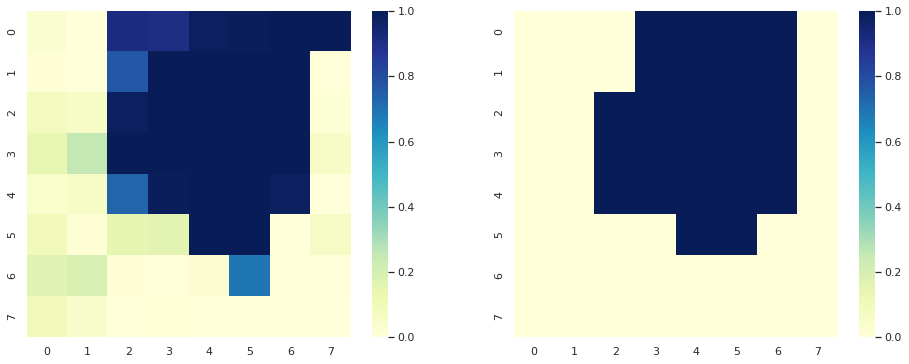

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(rescaled_pred, vmin=0, vmax=1, cmap='YlGnBu', ax=axs[0])
sns.heatmap(np.reshape(sorted_label, (8, 8)), vmin=0, vmax=1, cmap='YlGnBu', ax=axs[1])

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
slice_image = read_slide(slide, x=43008, y=4*7168, level=2, width=1792, height=1792)

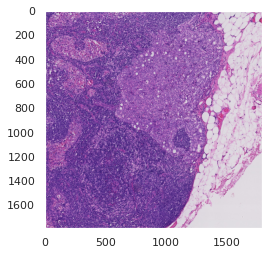

In [ ]:
plt.imshow(slice_image)

In [ ]:
mask_image = read_slide(tumor_mask, x=43008, y=4*7168, level=2, width=1792, height=1792)

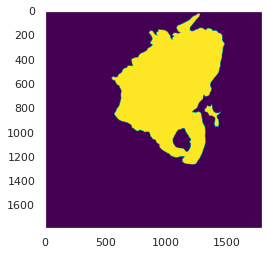

In [ ]:
plt.imshow(mask_image[:,:,0])

(-0.5, 1791.5, 1791.5, -0.5)

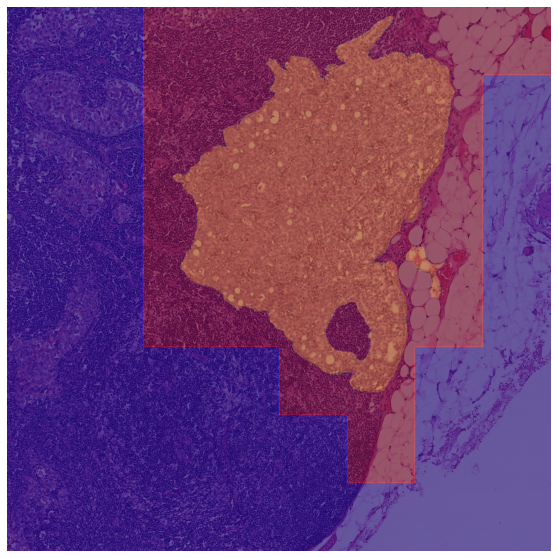

In [ ]:
mask_pred=np.zeros((224*8, 224*8))
for i in range(64):
  y = i % 8 
  x = i // 8 
  mask_pred[x*224:x*224+224, y*224:y*224+224] = 0. if sorted_pred[i] < 0.5 else 255. 

plt.figure(figsize=(18,10))
plt.grid(False)
plt.imshow(slice_image)
plt.imshow(mask_pred, cmap='jet',alpha=0.5) # Red regions contains cancer.
plt.imshow(mask_image[:,:,0], alpha=0.2)
plt.axis('off')

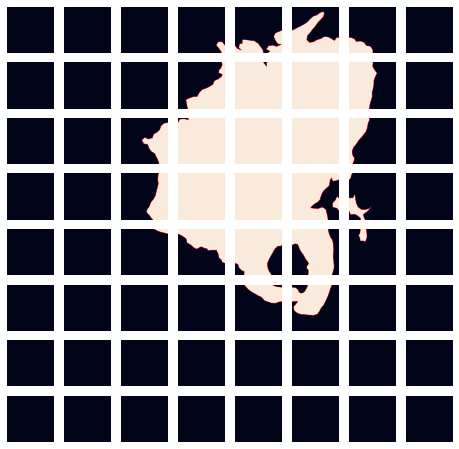

In [ ]:
#mask_image = mask_image[:,:,0]
plt.figure(figsize=(8, 8))
for i in range(len(m_patch_2)):
  img = m_patch_2[i]
  new_img = np.copy(img)
  if i in [13, 20, 21, 27, 28]:
    new_img.setflags(write=1)
    new_img[0, 0] = 0
  ax = plt.subplot(8, 8, i + 1)
  plt.imshow(new_img)
  plt.axis("off")

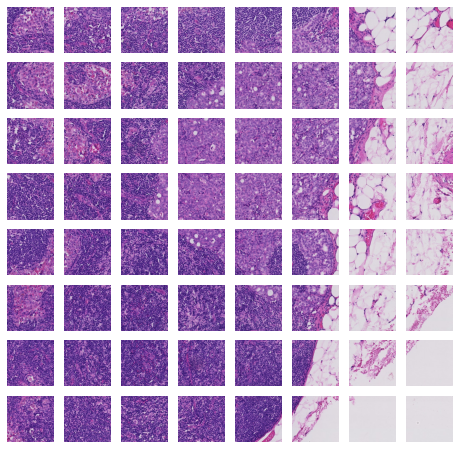

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(len(s_patch_2)):
  img = s_patch_2[i]
  ax = plt.subplot(8, 8, i + 1)
  plt.imshow(img)
  plt.axis("off")